Contribution to Downstream-User-Toolbox created as part of the IMMERSE project

* Author: Siren Rühs (s.ruhs@uu.nl)
* created on: Dec 6th 2022
* last updated on: Jan 25th 2023

# Comparing virtual particle trajectories from ocean-only (uncoupled) and ocean-wave (coupled) model simulations for the Mediterranean Sea

## 0. Getting started

* Make sure you (i) read the general README.md and - as described there - installed miniconda and required packages, and (ii) executed the script Parcels_CalcTraj.ipynb to create the full set of trajectories that is analyzed within this notebook OR downloaded the trajectory data set; if you did not execute Parcels_CalcTraj.ipynb and want to use the downoaded netcdf files, you have to set zarrdata = False in section 2.
* Carefully check and eventually adjust the path information in section 2 if necessary




## 1. General settings
Can nearly always stay untouched

### 1.1 Load Modules and check versions

In [1]:
import os.path
from glob import glob

import xarray as xr
import numpy as np
from xhistogram.xarray import histogram

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import ticker
from matplotlib import colors
from matplotlib.offsetbox import AnchoredText
from matplotlib import cm

In [2]:
# modified after: https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook

import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]            
        yield name
imports = list(set(get_imports()))
# get the version of the root package from only the name of the package
# via cross-checking the names of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))
for r in requirements:
    print("{}=={}".format(*r))

xarray==2022.12.0
matplotlib==3.6.2
numpy==1.24.1


## 2. Load and format trajectory data

In [3]:
############################

# set zarrdata to False if Parcels_CalcTraj.ipynb has not been executed
## then the trajectory data in netcdf format will be loaded
zarrdata = False

datapath = "./data/LAtrajectories/"

gridpath = "./data/domain/mesh_mask.nc"

############################


# Trajectories

tonetcdf = False # set to True if you want to save trajectory data in netcdf format

if zarrdata==True:
    trajpaths_csd = sorted(glob(f'{datapath}Parcels_CalcTraj_Data-coupled-sd_Release-GulfOfLion-t*_Integrate-fw-d30-dt25m_Sample-UV.zarr/'),
                          key=lambda f: int(''.join(filter(str.isdigit, f))))
    traj_csd = xr.open_mfdataset(trajpaths_csd,
                                concat_dim="start", combine="nested", engine="zarr")

    trajpaths_nc = sorted(glob(f'{datapath}Parcels_CalcTraj_Data-uncoupled_Release-GulfOfLion-t*_Integrate-fw-d30-dt25m_Sample-UV.zarr/'),
                          key=lambda f: int(''.join(filter(str.isdigit, f))))
    traj_nc = xr.open_mfdataset(trajpaths_nc,
                                concat_dim="start", combine="nested", engine="zarr")

    trajpaths_ncsd = sorted(glob(f'{datapath}Parcels_CalcTraj_Data-uncoupled-sd_Release-GulfOfLion-t*_Integrate-fw-d30-dt25m_Sample-UV.zarr/'),
                          key=lambda f: int(''.join(filter(str.isdigit, f))))
    traj_ncsd = xr.open_mfdataset(trajpaths_ncsd,
                                  concat_dim="start", combine="nested", engine="zarr")
    if tonetcdf==True:
        traj_csd.to_netcdf(datapath + "Trajectories_BestGuess_coupled-sd.nc")
        traj_nc.to_netcdf(datapath + "Trajectories_OldStandard_uncoupled.nc")
        traj_ncsd.to_netcdf(datapath + "Trajectories_Approximation_uncoupled-sd.nc")
else:
    traj_csd = xr.open_dataset(datapath + "Trajectories_BestGuess_coupled-sd.nc")
    traj_nc = xr.open_dataset(datapath + "Trajectories_OldStandard_uncoupled.nc")
    traj_ncsd = xr.open_dataset(datapath + "Trajectories_Approximation_uncoupled-sd.nc")

    
# Grid

grid = xr.open_dataset(gridpath, drop_variables=("x","y"))

In [4]:
traj_csd

<xarray.Dataset>
Dimensions:     (start: 73, trajectory: 87, obs: 31)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30
  * trajectory  (trajectory) int64 0 1 2 3 4 5 6 7 8 ... 79 80 81 82 83 84 85 86
Dimensions without coordinates: start
Data variables:
    U           (start, trajectory, obs) float32 ...
    V           (start, trajectory, obs) float32 ...
    beached     (start, trajectory, obs) float64 ...
    lat         (start, trajectory, obs) float64 ...
    lon         (start, trajectory, obs) float64 ...
    time        (start, trajectory, obs) datetime64[ns] ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.0

## 3. Perform calculations on trajectory data

### 3.1 Calculate speed along trajectory

In [5]:
def calc_trajspeed(trajset):
    u = trajset.U * 1852*60 * np.cos(trajset.lat * np.pi/180)
    v = trajset.V * 1852*60
    speed = (u**2 + v**2)**(1/2)
    return speed

In [6]:
trajspeed_csd = calc_trajspeed(traj_csd)
trajspeed_nc = calc_trajspeed(traj_nc)
trajspeed_ncsd = calc_trajspeed(traj_ncsd)

### 3.2 Check whether particles beached or got stucked
Explanation stucked particles: As we assumed floating particles, we only advected particles horizontally. Those particles may get "stucked" (that is, they are not moving anymore) within the ocean, in case there are rather persistent convergence zones (where the particle would normally downwell in case vertical velocities would be considered).

In [7]:
npart = traj_csd.lat.shape[0] * traj_csd.lat.shape[1]
print("Total number of released particles per dataset:", str(npart))

Total number of released particles per dataset: 6351


In [8]:
def calc_npaticles_beached(trajset):
    tmp = trajset.beached.sum(dim=("obs"))
    beached_trajset = (tmp.where(tmp != 0) / tmp.where(tmp != 0)).sum()
    return beached_trajset.values

In [9]:
print("number of beached particles:")
print("coupled with Stokes drift:", str(calc_npaticles_beached(traj_csd)),
      " (", str(round(calc_npaticles_beached(traj_csd)/npart*100)), "%)")
print("uncoupled without Stokes drift:", str(calc_npaticles_beached(traj_nc)),
      " (", str(round(calc_npaticles_beached(traj_nc)/npart*100)), "%)" )
print("uncoupled with Stokes drift:", str(calc_npaticles_beached(traj_ncsd)),
      " (", str(round(calc_npaticles_beached(traj_ncsd)/npart*100)), "%)" )

number of beached particles:
coupled with Stokes drift: 1.0  ( 0 %)
uncoupled without Stokes drift: 0.0  ( 0 %)
uncoupled with Stokes drift: 1.0  ( 0 %)


In [10]:
def calc_npaticles_stucked(trajspeed):
    tmp = xr.where(trajspeed <= 1e-8, trajspeed/trajspeed, trajspeed*0).sum(dim=('obs'))
    stucked_trajset = (tmp.where(tmp != 0) / tmp.where(tmp != 0)).sum()
    return stucked_trajset.values

In [11]:
print("number of stucked particles:")
tmp = calc_npaticles_stucked(trajspeed_csd)
print("coupled with Stokes drift:", str(tmp),
      " (", str(round(tmp/npart*100)), "%)")
tmp = calc_npaticles_stucked(trajspeed_nc)
print("uncoupled without Stokes drift:", str(tmp),
      " (", str(round(tmp/npart*100)), "%)" )
tmp = calc_npaticles_stucked(trajspeed_ncsd)
print("uncoupled with Stokes drift:", str(tmp),
      " (", str(round(tmp/npart*100)), "%)" )

number of stucked particles:
coupled with Stokes drift: 0.0  ( 0 %)
uncoupled without Stokes drift: 0.0  ( 0 %)
uncoupled with Stokes drift: 1.0  ( 0 %)


## 4. Plotting:  exemplary trajectories, histograms of particle positions, retention rate and dispersal area

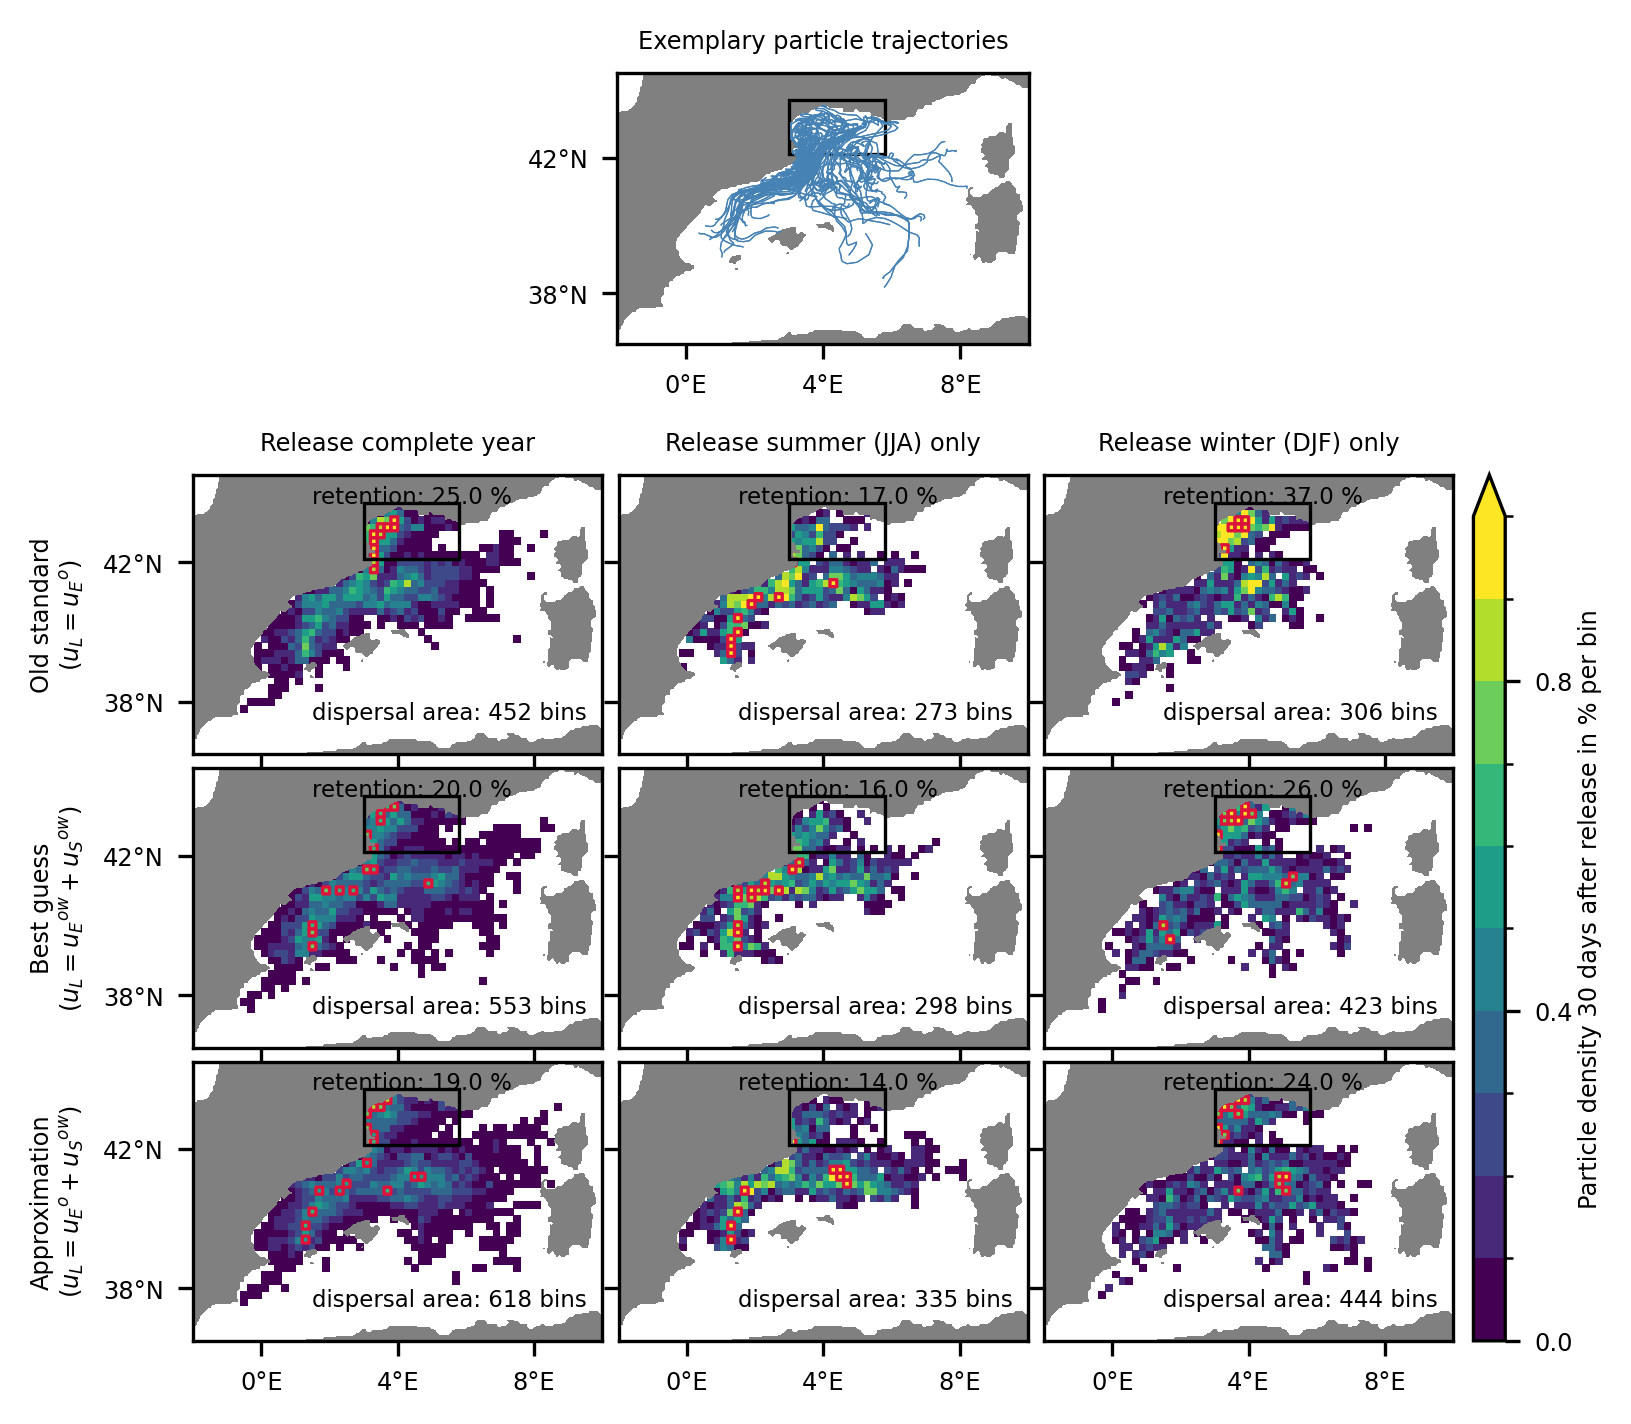

In [12]:
obsplot = 30

lonmin = 3
lonmax = 5.6
latmin = 42.1
latmax = 43.5
step = 0.2

lonmin_plot = -2
lonmax_plot = 10
latmin_plot = 36.5
latmax_plot = 44.5

col_nc = 'grey'
col_csd = 'darkblue'
col_cnosd = 'lightblue'
col_ncsd = 'lightcoral'

colm = cm.viridis 
levs = np.arange(0, 1.1, 0.1)
norm = colors.BoundaryNorm(boundaries=levs, ncolors=colm.N)
nctic=3
bins_lon = np.arange(-6,36,0.2); bins_lat =  np.arange(30.1,47,0.2)
highproblev = 90

fs='xx-small'


def plot_bathy():
    var = grid.mbathy
    var.rename({'x':'lon', 'y':'lat'})
    ax.contourf(grid.glamf.isel(time_counter=0), grid.gphif.isel(time_counter=0),
                var.isel(time_counter=0),[0,1],
                colors='grey')

def plot_releasebox():
    rect = patches.Rectangle((lonmin, latmin), lonmax-lonmin+step, latmax-latmin+step, 
                             linewidth=0.8,edgecolor='k', facecolor='none')
    ax.add_patch(rect)
    
def plot_2Dhist(var1):
    pos_y = var1.isel(obs=obsplot).lat.stack(trajstack=('trajectory','start'))
    pos_x = var1.isel(obs=obsplot).lon.stack(trajstack=('trajectory','start'))
    hist2D = histogram(pos_x, pos_y, bins=[bins_lon, bins_lat])
    hist2D_plot = hist2D.transpose()/hist2D.sum().values*100
    map = ax.pcolor(hist2D_plot.lon_bin, hist2D_plot.lat_bin,
                    hist2D_plot.where(hist2D_plot != 0),
                    cmap=colm, norm = norm,
                    shading='nearest')
    release_box = (((hist2D_plot.lon_bin >= lonmin) & (hist2D_plot.lon_bin <= lonmax)) &
                   ((hist2D_plot.lat_bin >= latmin) & (hist2D_plot.lat_bin <= latmax)))
    tmp = hist2D_plot.where(release_box)
    retention = tmp.sum()
    ax.annotate('retention: ' + str(retention.round().values) + ' %', (1.5, latmax+step), fontsize=5.5)
    area_bins = (hist2D_plot.where(hist2D_plot != 0)/hist2D_plot.where(hist2D_plot != 0)).sum()
    ax.text(1.5, 37.5, 'dispersal area: ' + str(int(area_bins.round().values)) + ' bins', fontsize=5.5)
    tmp2 = np.sort(hist2D_plot.stack(binstack=('lon_bin','lat_bin')))
    tmp3 = np.cumsum(tmp2)
    highprob = xr.DataArray(tmp2).where(tmp3 >= highproblev).squeeze(drop=True).min()
    ax.pcolor(hist2D_plot.lon_bin, hist2D_plot.lat_bin,
              hist2D_plot.where(hist2D_plot >= highprob),
              alpha=1.0, edgecolor='crimson', facecolor='none',
              linewidth=0.8,
              shading='nearest')
    del tmp, tmp2, tmp3
    return map

def build_subplot(var1,xticklabel=True,yticklabel=True):
    map = plot_2Dhist(var1)
    plot_bathy()
    plot_releasebox()
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks([0,4,8])
    ax.set_yticks([38,42])
    ax.set_xticklabels(['0°E','4°E','8°E'])
    ax.set_yticklabels(['38°N','42°N'])
    if xticklabel==False:
        ax.set_xticklabels([])
    if yticklabel==False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map

    
fig = plt.figure(figsize=(6,5.6), dpi=300, constrained_layout=False)
gs2 = fig.add_gridspec(nrows=100, ncols=3, 
                      left=0.1, right=0.8,
                      wspace=0.03, hspace=0.05)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.1, right=0.8,
                      top=0.8,
                      wspace=0.04, hspace=0.05)
gscbar = fig.add_gridspec(nrows=4, ncols=100, 
                          left=0.1, right=1,
                          top=0.8,
                          wspace=0.04, hspace=0.05)


# Exemplary trajectories

ax = fig.add_subplot(gs2[2:23,1])
plot_bathy()
plot_releasebox()
ax.set_xlim([lonmin_plot,lonmax_plot])
ax.set_ylim([latmin_plot,latmax_plot])
ax.set_xticks([0,4,8])
ax.set_yticks([38,42])
ax.set_xticklabels(['0°E','4°E','8°E'])
ax.set_yticklabels(['38°N','42°N'])
ax.tick_params(axis='both', labelsize=fs)
for i in np.arange(1,80,5):
    for j in np.arange(1,70,10):
        plt.plot(traj_ncsd.lon.isel(start=j, trajectory=i), traj_ncsd.lat.isel(start=j, trajectory=i), color='steelblue', linewidth=0.3)
        plt.plot(traj_ncsd.lon.isel(start=j, trajectory=i), traj_ncsd.lat.isel(start=j, trajectory=i), color='steelblue', linewidth=0.3)
ax.set_title('Exemplary particle trajectories', fontsize=fs)


# Total distributions

ax = fig.add_subplot(gs[1,0])
var1 = traj_nc
map = build_subplot(var1, xticklabel=False)
ax.set_title('Release complete year', fontsize=fs)
ax.set_ylabel('Old standard\n($u_L = {u_E}^{o}$)', fontsize=fs)

ax = fig.add_subplot(gs[2,0])
var1 = traj_csd
map = build_subplot(var1, xticklabel=False)
ax.set_ylabel('Best guess\n($u_L = {u_E}^{ow} + {u_S}^{ow}$)', fontsize=fs)

ax = fig.add_subplot(gs[3,0])
var1 = traj_ncsd
map = build_subplot(var1)
ax.set_ylabel('Approximation\n($u_L = {u_E}^{o} + {u_S}^{ow}$)', fontsize=fs)


# Summer distributions

start_use = slice(31,49)

ax = fig.add_subplot(gs[1,1])
var1 = traj_nc.isel(start=start_use)
map = build_subplot(var1, xticklabel=False, yticklabel=False)
ax.set_title('Release summer (JJA) only', fontsize=fs)

ax = fig.add_subplot(gs[2,1])
var1 = traj_csd.isel(start=start_use)
map = build_subplot(var1, xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[3,1])
var1 = traj_ncsd.isel(start=start_use)
map = build_subplot(var1, yticklabel=False)


# Winter distributions (DJF)

start1 = np.arange(0,12); start2 = np.arange(67,73); start_use = [*start1, *start2]

ax = fig.add_subplot(gs[1,2])
var1 = traj_nc.isel(start=start_use)
map = build_subplot(var1, xticklabel=False, yticklabel=False)
ax.set_title('Release winter (DJF) only', fontsize=fs)

ax = fig.add_subplot(gs[2,2])
var1 = traj_csd.isel(start=start_use)
map = build_subplot(var1, xticklabel=False, yticklabel=False)
ax.text(14, latmin_plot + (latmax_plot-latmin_plot)/2,
        'Particle density 30 days after release in % per bin',
        ha='center', va='center', fontsize=fs, rotation=90)

ax = fig.add_subplot(gs[3,2])
var1 = traj_ncsd.isel(start=start_use)
map = build_subplot(var1, yticklabel=False)
cbaxes = fig.add_subplot(gscbar[1:5,79:81])
cbar = plt.colorbar(map, cax = cbaxes, orientation='vertical', extend='max')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()
